# Homework 5 - Independent Component Analysis

Brennan McFarland  
bfm21

Exercise 1: Write a gradient-based algorithm to learn the independent components, i.e. the mixing matrix,
given a matrix where the rows contain samples from different sources.

## Learning Independent Components

## Synthetic Data

### Loading the Data

In [1]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('data/bach.wav')
_, dataSpeech = wavfile.read('data/speech.wav')

### Normalizing the Data

In [2]:
import numpy as np

def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

gtruthS = audionorm([dataBach, dataSpeech])

### Mixing Audio

In [3]:
def simpleMixer(S):
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

def drawDataWithMixingMatrix(data, mat):
    # plot data points
    plt.scatter(data[0], data[1], s=1)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')

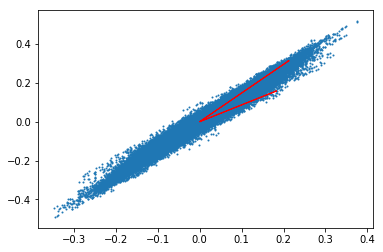

In [5]:
X, gtruthA = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA)

In [6]:
wavfile.write('data/mixedTrackA.wav', srate, X[0])
wavfile.write('data/mixedTrackB.wav', srate, X[1])

### Optimization Functions

In [7]:
from bsslib import bss

#### Verifying on Synthetic Data

this may help (TODO: remove this): http://mplab.ucsd.edu/~marni/Igert/ICA_tutorial.pdf

In [8]:
from bsslib import syntheticDataGenerate

# quantity of data points
nsamples = 10000
# specific mixing matrix (for illustration purpose)
verifyA = np.asarray([[-1, 1],[2, 2]])
# generate synthetic data
synthData = syntheticDataGenerate(verifyA, nsamples)
# do optimization with bss function
estimateA, recoverData = bss(synthData)

neg_gradA:  [[-1.49252357e+04 -1.48430229e+02]
 [-1.75879645e+01 -2.98093223e+04]]
neg_gradA:  [[-13431.54946101    -51.77774282]
 [   264.17790972 -26828.4512475 ]]
neg_gradA:  [[-12088.7737344    -101.33742905]
 [   188.35710168 -24144.89556247]]
neg_gradA:  [[-10879.79443949   -112.48983561]
 [   190.71407748 -21730.06583271]]
neg_gradA:  [[ -9791.69253035   -113.11921356]
 [   192.35499619 -19556.82074139]]
neg_gradA:  [[ -8812.37197521   -116.21085337]
 [   199.31672199 -17600.866388  ]]
neg_gradA:  [[ -7930.93021345   -117.70522507]
 [   213.88863958 -15840.49476615]]
neg_gradA:  [[ -7137.65695815   -114.98855121]
 [   219.21019145 -14256.18771489]]
neg_gradA:  [[ -6423.67547658   -120.77730677]
 [   228.9558932  -12830.15172812]]
neg_gradA:  [[ -5781.14350767   -125.75984816]
 [   223.73291233 -11546.67684321]]
neg_gradA:  [[ -5202.75797429   -128.75747665]
 [   234.83218687 -10391.5593546 ]]
neg_gradA:  [[-4682.25769593  -129.84744176]
 [  233.54331804 -9351.94159696]]
neg_grad

neg_gradA:  [[  848.47612328 -1403.49579742]
 [ 2863.23503715  1701.40366297]]
neg_gradA:  [[  868.35812161 -1406.16189297]
 [ 2837.4393677   1755.33343548]]
neg_gradA:  [[  894.03879614 -1412.03393844]
 [ 2834.63854865  1812.70087917]]
neg_gradA:  [[  913.77439693 -1357.93362495]
 [ 2809.11231722  1807.47658592]]
neg_gradA:  [[  933.30616449 -1335.44937356]
 [ 2789.43802886  1833.07751429]]
neg_gradA:  [[  952.09730032 -1300.04880419]
 [ 2770.51297038  1843.24082437]]
neg_gradA:  [[  947.43372522 -1282.42325936]
 [ 2673.65995118  1871.0546264 ]]
neg_gradA:  [[  953.71603756 -1314.07658199]
 [ 2618.48162388  1952.54826698]]
neg_gradA:  [[  968.30152738 -1351.99880457]
 [ 2585.52892877  2043.14294785]]
neg_gradA:  [[  956.70838763 -1313.00328503]
 [ 2463.34653522  2040.1814651 ]]
neg_gradA:  [[  963.50746609 -1303.98532311]
 [ 2409.4671128   2069.33248501]]
neg_gradA:  [[  967.92341651 -1223.79242359]
 [ 2351.29289891  2006.02194038]]
neg_gradA:  [[  951.94860646 -1216.99970075]
 [ 2242

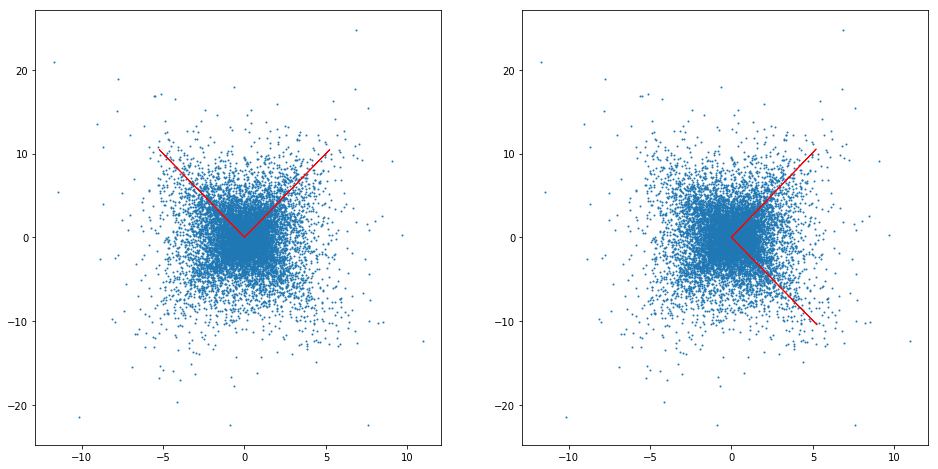

In [9]:
def compareMixingMatrix(data, matA, matB):
    plt.figure(figsize=(16, 8))
    # plot first mixing matrix
    plt.subplot(1,2,1)
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    plt.subplot(1,2,2)
    drawDataWithMixingMatrix(data, matB)
    
compareMixingMatrix(synthData, verifyA, estimateA)

### Initializing the Mixture Model

In [10]:
# randomly pick coordinates as center of Gaussian distribution
def randinitMean(n, drange):
    mu = []
    for m in range(n):
        mu.append([np.random.uniform(drange[i]['MIN'], drange[i]['MAX']) for i in range(len(drange))])
    # return inf form of numpy.ndarray
    return np.asarray(mu)

def randOrthogonalMatrix(ndim):
    ortmat = np.random.normal(size=[ndim,ndim])
    for i in range(ndim):
        # remove components exist in vector before
        r = ortmat[:,i]
        if i > 0:
            b = ortmat[:,range(i)]
            r = r - b.dot(b.T.dot(r))
        # normalize current column
        ortmat[:,i] = r / np.sqrt(r.T.dot(r))
    return ortmat

def randinitCovarianceND(n, ndim=2):
    sigma = []
    for m in range(n):
        # create eigen vectors as an orthogonal matrix
        eigenVector = randOrthogonalMatrix(ndim)
        # randomly positive values as eigen value
        eigenValue = abs(np.random.normal(size=ndim))
        # compose covariance matrix
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    return np.asarray(sigma)

In [11]:
ngmm = 2 # quantity of Gaussian Mixture Model
ndim = 2 # TODO: not exactly sure what this does, find out?

# get information of range on each dimension
dataRange = []
for i in range(data.shape[1]):
    dataRange.append({'MIN': min(data[:,i]), 'MAX': max(data[:,i])})
    
mu = randinitMean(ngmm, dataRange)

sigma = randinitCovarianceND(ngmm, ndim)
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

NameError: name 'data' is not defined

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

gmmplot(dataBach, gmm)